In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Physical parameters
D = 5.0
De = 0.01
A = 0.5
epsilon = 0.1
psi = 0.1

# Define adaptive activation function
class AdaptiveTanh(nn.Module):
    def __init__(self):
        super(AdaptiveTanh, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, x):
        beta_clamped = torch.clamp(self.beta, min=0.5, max=5.0)  # Tightened clamp
        return self.alpha * torch.tanh(beta_clamped * x)

# Neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.adaptive_tanh = AdaptiveTanh()
        self.net = nn.Sequential(
            nn.Linear(1, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 6)
        )
        self.log_E = nn.Parameter(torch.tensor(0.0))
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0.01)

    def forward(self, x):
        return self.net(x)

    @property
    def E(self):
        return torch.exp(self.log_E)

# Loss function with weighted stress residuals
def compute_loss(model, x_coll, x_bc0, x_bc1):
    outputs = model(x_coll)
    u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)

    def safe_grad(y, x):
        grad_output = grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, allow_unused=True)[0]
        return grad_output if grad_output is not None else torch.zeros_like(x)

    grad_u = safe_grad(u, x_coll)
    grad_L = safe_grad(L, x_coll)
    grad_e = safe_grad(e, x_coll)
    grad_tau_xx = safe_grad(tau_xx, x_coll)
    grad_tau_yy = safe_grad(tau_yy, x_coll)
    grad_tau_zz = safe_grad(tau_zz, x_coll)

    residual1 = e * L * u - 1.0
    residual2 = (tau_xx - tau_zz) - u
    E = torch.clamp(model.E, min=1e-8)
    trace_stress = tau_xx + tau_yy + tau_zz
    exp_term = torch.clamp((De * epsilon / E) * trace_stress, min=-50, max=50)
    denominator = torch.clamp(tau_xx - tau_zz, min=1e-8)
    ratio = torch.clamp((tau_yy - tau_zz) / denominator, min=1e-8)
    residual3 = grad_L + A * torch.sqrt(ratio)
    residual4_xx = (De * u * grad_tau_xx + grad_u * (-2 * De * tau_xx + 4 * psi * De * tau_xx - 2 * E) + tau_xx * torch.exp(exp_term))
    residual4_yy = (De * u * grad_tau_yy + grad_L * (-2 * De * u / L * tau_yy + 4 * psi * De * tau_yy / L - 2 * E * u / L) + tau_yy * torch.exp(exp_term))
    residual4_zz = (De * u * grad_tau_zz + grad_e * (-2 * De * u / e * tau_zz + 4 * psi * De * tau_zz / e - 2 * E * u / e) + tau_zz * torch.exp(exp_term))

    outputs_bc0 = model(x_bc0)
    outputs_bc1 = model(x_bc1)
    bc_loss = ((outputs_bc0[:, 0] - 1.0) ** 2 + (outputs_bc0[:, 1] - 1.0) ** 2 + (outputs_bc0[:, 2] - 1.0) ** 2 +
               (outputs_bc0[:, 3] - 1.0) ** 2 + (outputs_bc0[:, 4] - 0.5) ** 2 + (outputs_bc0[:, 5] - 0.0) ** 2).mean()
    bc_loss += ((outputs_bc1[:, 0] - D) ** 2).mean()

    grad_penalty = (grad_u.pow(2).mean() + grad_L.pow(2).mean() + grad_e.pow(2).mean() +
                    grad_tau_xx.pow(2).mean() + grad_tau_yy.pow(2).mean() + grad_tau_zz.pow(2).mean())

    pde_loss = (residual1.pow(2).mean() + residual2.pow(2).mean() + residual3.pow(2).mean() +
                10.0 * residual4_xx.pow(2).mean() + 10.0 * residual4_yy.pow(2).mean() + 10.0 * residual4_zz.pow(2).mean())

    total_loss = pde_loss + 1.0 * bc_loss + 0.00001 * grad_penalty
    return total_loss, pde_loss, bc_loss, grad_penalty, (residual4_xx.pow(2).mean(), residual4_yy.pow(2).mean(), residual4_zz.pow(2).mean())

# Plotting function
def plot_solutions(model, x_range=None, seed=None):
    model.eval()
    if x_range is None:
        x_range = torch.linspace(0.0, 1.0, 1000).reshape(-1, 1)
    
    with torch.no_grad():
        outputs = model(x_range)
        u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)
        x_np = x_range.numpy().flatten()
        u_np = u.numpy().flatten()
        L_np = L.numpy().flatten()
        e_np = e.numpy().flatten()
        tau_xx_np = tau_xx.numpy().flatten()
        tau_yy_np = tau_yy.numpy().flatten()
        tau_zz_np = tau_zz.numpy().flatten()
        alpha_beta = (model.adaptive_tanh.alpha.item(), model.adaptive_tanh.beta.item())
        alpha_beta_str = f'alpha={alpha_beta[0]:.4f}, beta={alpha_beta[1]:.4f}'
    
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle(f'PINN Solutions vs Spatial Coordinate x\nSeed: {seed}, Adaptive Tanh: {alpha_beta_str}', fontsize=16)
    
    axs[0, 0].plot(x_np, u_np, 'b-', label='u(x)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    
    axs[0, 1].plot(x_np, L_np, 'r-', label='L(x)')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('L')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    
    axs[1, 0].plot(x_np, e_np, 'g-', label='e(x)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('e')
    axs[1, 0].grid(True)
    axs[1, 0].legend()
    
    axs[1, 1].plot(x_np, tau_xx_np, 'm-', label=r'$\tau_{xx}(x)$')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel(r'$\tau_{xx}$')
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    
    axs[2, 0].plot(x_np, tau_yy_np, 'c-', label=r'$\tau_{yy}(x)$')
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel(r'$\tau_{yy}$')
    axs[2, 0].grid(True)
    axs[2, 0].legend()
    
    axs[2, 1].plot(x_np, tau_zz_np, 'k-', label=r'$\tau_{zz}(x)$')
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel(r'$\tau_{zz}$')
    axs[2, 1].grid(True)
    axs[2, 1].legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f'pinn_solutions_seed_{seed}.png')
    plt.close()

# Training setup
def generate_points():
    x_coll = torch.linspace(0, 1, 2000).reshape(-1, 1)
    x_coll.requires_grad_(True)
    x_bc0 = torch.zeros(1, 1, requires_grad=True)
    x_bc1 = torch.ones(1, 1, requires_grad=True)
    return x_coll, x_bc0, x_bc1

# Training loop for multiple seeds
seeds = [4567, 1234, 5678, 6789] for De=0.01, A=0.5, ep=0.1, psi=0.1
#seeds = [8901, 1234, 9012, 4567,1013]
for seed in seeds:
    print(f"\nStarting training with seed {seed}")
    torch.manual_seed(seed)
    model = PINN()
    optimizer = torch.optim.Adam([
        {'params': [p for p in model.parameters() if p is not model.adaptive_tanh.alpha and p is not model.adaptive_tanh.beta], 'lr': 0.001, 'weight_decay': 1e-5},
        {'params': [model.adaptive_tanh.alpha, model.adaptive_tanh.beta], 'lr': 0.001, 'weight_decay': 1e-5}
    ], lr=0.001)  # Unified learning rate with weight decay
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10000)
    x_coll, x_bc0, x_bc1 = generate_points()

    best_loss = float('inf')
    last_losses = []
    for epoch in range(30000):  # Reduced to 10,000 epochs
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss, grad_penalty, (res_xx, res_yy, res_zz) = compute_loss(model, x_coll, x_bc0, x_bc1)
        if torch.isnan(total_loss):
            print(f"Training stalled at epoch {epoch} due to NaN loss")
            print(f"Last 10 losses: {last_losses[-10:]}")
            break
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Increased to 2.0
        optimizer.step()
        scheduler.step()

        last_losses.append(total_loss.item())
        if len(last_losses) > 10:
            last_losses.pop(0)

        if epoch % 100 == 0:
            print(f"Epoch {epoch:04d} | Total Loss: {total_loss.item():.2e} | PDE: {pde_loss.item():.2e} | "
                  f"BC: {bc_loss.item():.2e} | Grad: {grad_penalty.item():.2e} | E: {model.E.item():.4f} | "
                  f"Alpha: {model.adaptive_tanh.alpha.item():.4f} | Beta: {model.adaptive_tanh.beta.item():.4f} | "
                  f"Res_xx: {res_xx.item():.2e} | Res_yy: {res_yy.item():.2e} | Res_zz: {res_zz.item():.2e}")
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save(model.state_dict(), f'pinn2_adaptive_seed_{seed}.pth')

    # Plot solutions after training
    model.load_state_dict(torch.load(f'pinn_adaptive_seed_De0.1{seed}.pth'))
    plot_solutions(model, seed=seed)


Starting training with seed 8901
Epoch 0000 | Total Loss: 8.32e+04 | PDE: 8.32e+04 | BC: 2.95e+01 | Grad: 5.90e-01 | E: 1.0010 | Alpha: 0.9990 | Beta: 0.9990 | Res_xx: 1.39e-02 | Res_yy: 4.14e-01 | Res_zz: 1.82e+01
Epoch 0100 | Total Loss: 6.32e+00 | PDE: 5.67e-01 | BC: 5.75e+00 | Grad: 1.26e+00 | E: 0.9328 | Alpha: 1.0093 | Beta: 0.9980 | Res_xx: 2.94e-02 | Res_yy: 7.70e-04 | Res_zz: 1.91e-03
Epoch 0200 | Total Loss: 4.16e+00 | PDE: 5.91e-01 | BC: 3.56e+00 | Grad: 7.28e+00 | E: 0.8671 | Alpha: 1.0395 | Beta: 1.0241 | Res_xx: 2.03e-02 | Res_yy: 4.89e-03 | Res_zz: 8.64e-03
Epoch 0300 | Total Loss: 2.91e+00 | PDE: 5.17e-01 | BC: 2.39e+00 | Grad: 1.73e+01 | E: 0.8133 | Alpha: 1.0522 | Beta: 1.0360 | Res_xx: 1.16e-02 | Res_yy: 2.50e-03 | Res_zz: 1.19e-02
Epoch 0400 | Total Loss: 3.01e+00 | PDE: 1.36e+00 | BC: 1.64e+00 | Grad: 3.12e+01 | E: 0.7754 | Alpha: 1.0673 | Beta: 1.0448 | Res_xx: 1.23e-02 | Res_yy: 7.88e-03 | Res_zz: 9.20e-02
Epoch 0500 | Total Loss: 1.97e+00 | PDE: 8.29e-01 | BC: 

KeyboardInterrupt: 

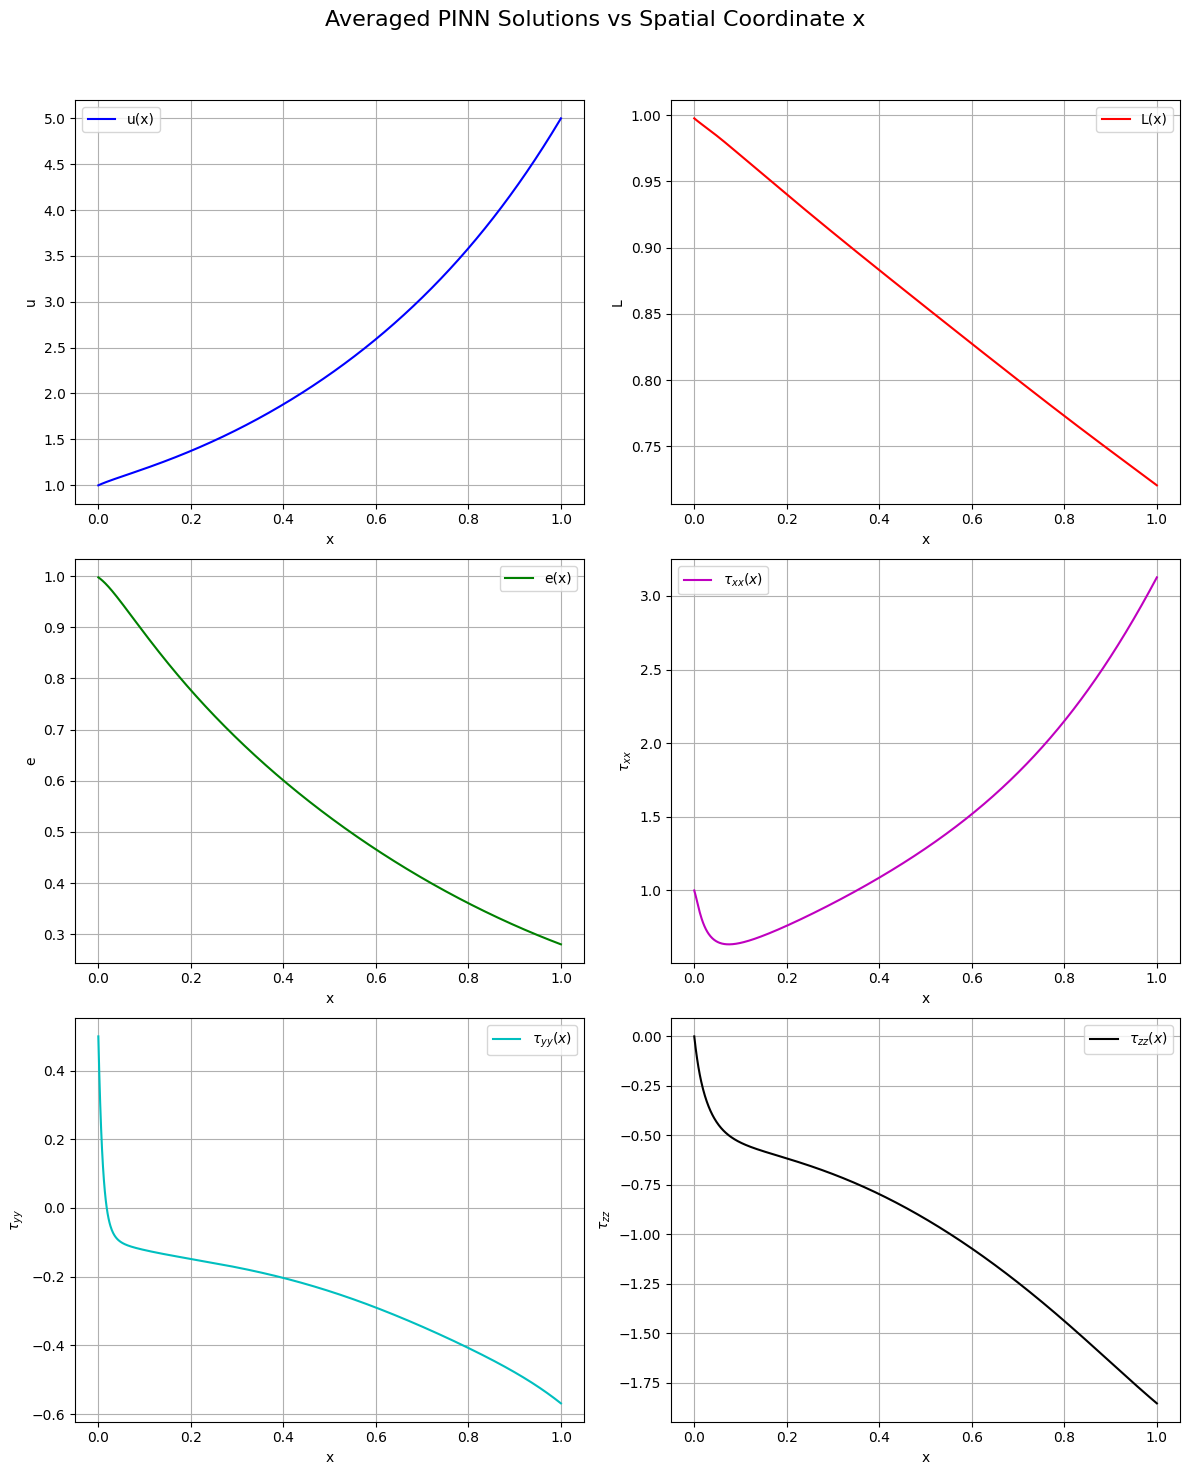

In [8]:
# Training loop (simplified, assuming models are already trained and saved)
seeds = [4567, 1234, 5678, 6789]
models = []
x_range = torch.linspace(0.0, 1.0, 1000).reshape(-1, 1)

for seed in seeds:
    model = PINN()
    model.load_state_dict(torch.load(f'pinn_adaptive_seed_{seed}.pth'))
    model.eval()
    with torch.no_grad():
        models.append(model(x_range))

# Average predictions
avg_outputs = torch.stack(models).mean(dim=0)
u_avg, L_avg, e_avg, tau_xx_avg, tau_yy_avg, tau_zz_avg = torch.split(avg_outputs, 1, dim=1)
x_np = x_range.numpy().flatten()
u_np = u_avg.numpy().flatten()
L_np = L_avg.numpy().flatten()
e_np = e_avg.numpy().flatten()
tau_xx_np = tau_xx_avg.numpy().flatten()
tau_yy_np = tau_yy_avg.numpy().flatten()
tau_zz_np = tau_zz_avg.numpy().flatten()

# Plotting averaged solutions
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('Averaged PINN Solutions vs Spatial Coordinate x', fontsize=16)

axs[0, 0].plot(x_np, u_np, 'b-', label='u(x)')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('u')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].plot(x_np, L_np, 'r-', label='L(x)')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('L')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].plot(x_np, e_np, 'g-', label='e(x)')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('e')
axs[1, 0].grid(True)
axs[1, 0].legend()

axs[1, 1].plot(x_np, tau_xx_np, 'm-', label=r'$\tau_{xx}(x)$')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel(r'$\tau_{xx}$')
axs[1, 1].grid(True)
axs[1, 1].legend()

axs[2, 0].plot(x_np, tau_yy_np, 'c-', label=r'$\tau_{yy}(x)$')
axs[2, 0].set_xlabel('x')
axs[2, 0].set_ylabel(r'$\tau_{yy}$')
axs[2, 0].grid(True)
axs[2, 0].legend()

axs[2, 1].plot(x_np, tau_zz_np, 'k-', label=r'$\tau_{zz}(x)$')
axs[2, 1].set_xlabel('x')
axs[2, 1].set_ylabel(r'$\tau_{zz}$')
axs[2, 1].grid(True)
axs[2, 1].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('pinn_solutions_avg.png')
plt.show()  # Added to display the plot

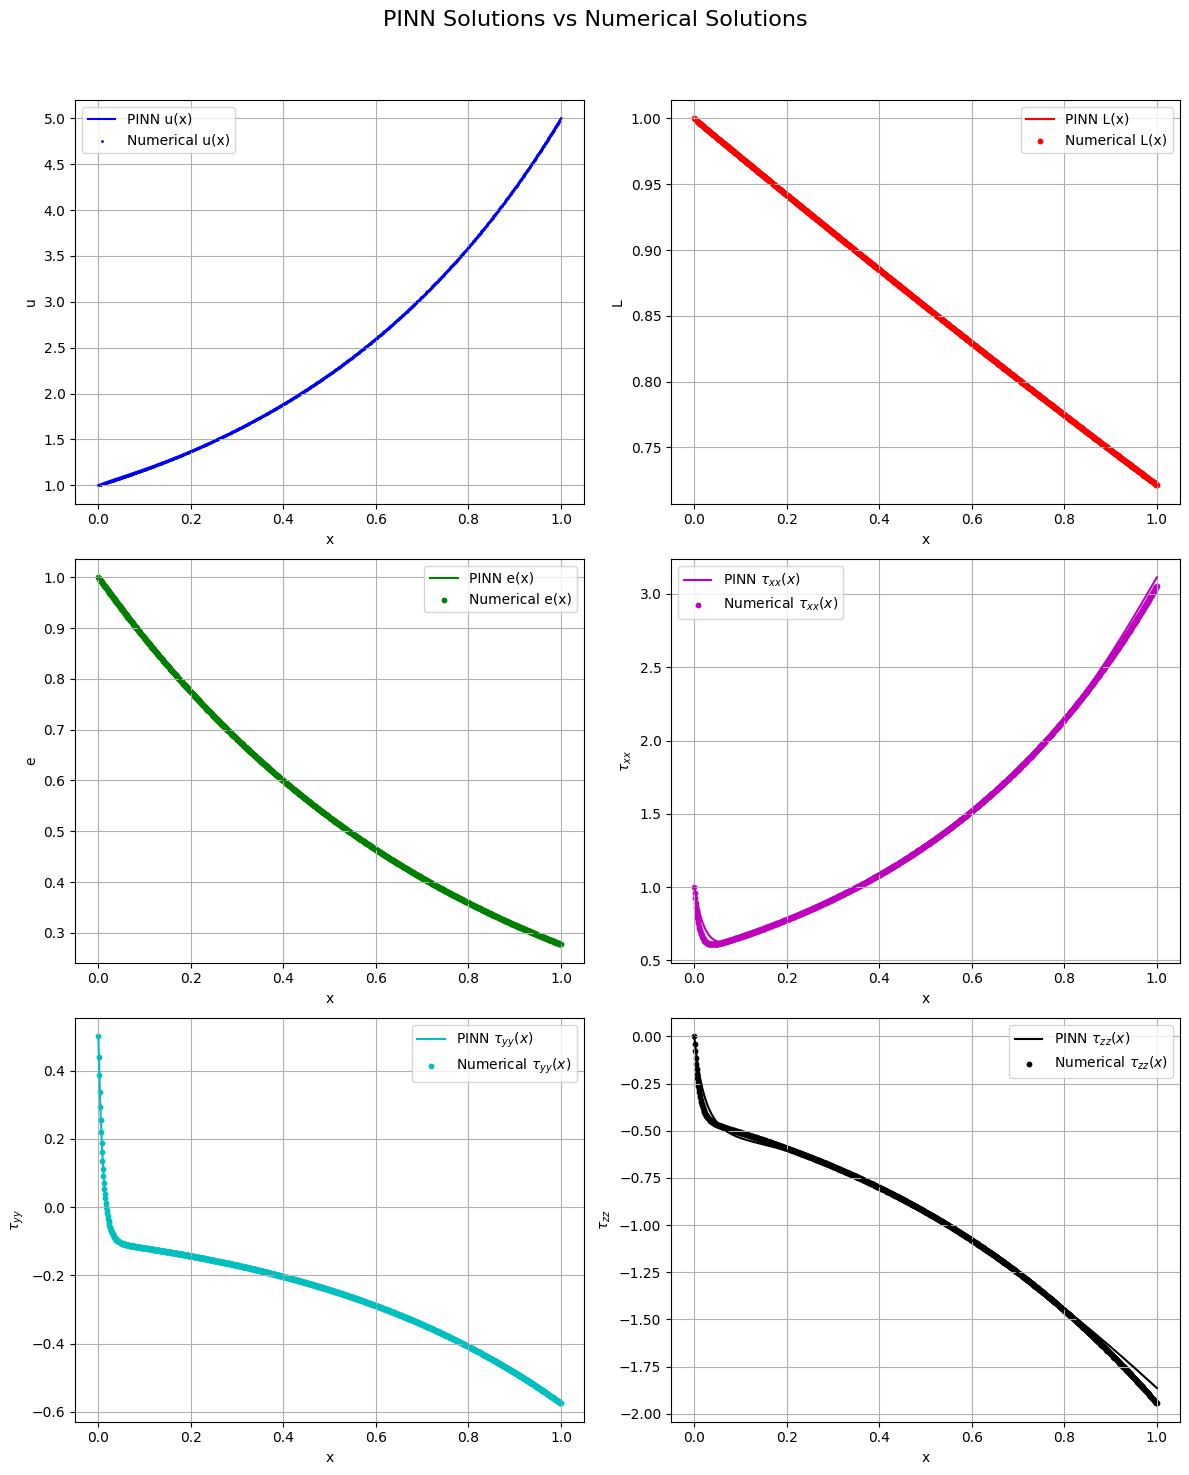

In [9]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os 

def plot_solutions_with_numerical(model, x_range=None, numerical_df=None):
    """
    Plot the PINN solutions for all variables alongside numerical solutions.

    Parameters:
    model: Trained PINN model
    x_range: Optional tensor of x values, if None generates default range
    numerical_df: DataFrame containing numerical solutions
    """
    # Set model to evaluation mode
    model.eval()

    # Generate x points if not provided
    if x_range is None:
        x_range = torch.linspace(0.0, 1.0, 1000).reshape(-1, 1)  # [1000,1]

    # Ensure x_range requires no gradient for plotting
    with torch.no_grad():
        # Get predictions
        outputs = model(x_range)  # [1000,6]
        u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)  # Each: [1000,1]

        # Convert to numpy for plotting
        x_np = x_range.numpy().flatten()  # [1000]
        u_np = u.numpy().flatten()        # [1000]
        L_np = L.numpy().flatten()        # [1000]
        e_np = e.numpy().flatten()        # [1000]
        tau_xx_np = tau_xx.numpy().flatten()  # [1000]
        tau_yy_np = tau_yy.numpy().flatten()  # [1000]
        tau_zz_np = tau_zz.numpy().flatten()  # [1000]

    # Extract numerical solutions from DataFrame
    x_numerical = numerical_df["x"].values
    L_numerical = numerical_df["L"].values
    u_numerical = numerical_df["u"].values
    e_numerical = numerical_df["e"].values
    tau_xx_numerical = numerical_df["tau_xx"].values
    tau_yy_numerical = numerical_df["tau_yy"].values
    tau_zz_numerical = numerical_df["tau_zz"].values

    # Create separate plots for each variable
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    fig.suptitle('PINN Solutions vs Numerical Solutions', fontsize=16)

    # Plot u
    axs[0, 0].plot(x_np, u_np, 'b-', label='PINN u(x)')
    axs[0, 0].scatter(x_numerical, u_numerical, color='b', marker='o', label='Numerical u(x)', s=1)
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('u')
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Plot L
    axs[0, 1].plot(x_np, L_np, 'r-', label='PINN L(x)')
    axs[0, 1].scatter(x_numerical, L_numerical, color='r', marker='o', label='Numerical L(x)', s=10)
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('L')
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Plot e
    axs[1, 0].plot(x_np, e_np, 'g-', label='PINN e(x)')
    axs[1, 0].scatter(x_numerical, e_numerical, color='g', marker='o', label='Numerical e(x)', s=10)
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('e')
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Plot tau_xx
    axs[1, 1].plot(x_np, tau_xx_np, 'm-', label=r'PINN $\tau_{xx}(x)$')
    axs[1, 1].scatter(x_numerical, tau_xx_numerical, color='m', marker='o', label=r'Numerical $\tau_{xx}(x)$', s=10)
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel(r'$\tau_{xx}$')
    axs[1, 1].grid(True)
    axs[1, 1].legend()

    # Plot tau_yy
    axs[2, 0].plot(x_np, tau_yy_np, 'c-', label=r'PINN $\tau_{yy}(x)$')
    axs[2, 0].scatter(x_numerical, tau_yy_numerical, color='c', marker='o', label=r'Numerical $\tau_{yy}(x)$', s=10)
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel(r'$\tau_{yy}$')
    axs[2, 0].grid(True)
    axs[2, 0].legend()

    # Plot tau_zz
    axs[2, 1].plot(x_np, tau_zz_np, 'k-', label=r'PINN $\tau_{zz}(x)$')
    axs[2, 1].scatter(x_numerical, tau_zz_numerical, color='k', marker='o', label=r'Numerical $\tau_{zz}(x)$', s=10)
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel(r'$\tau_{zz}$')
    axs[2, 1].grid(True)
    axs[2, 1].legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust top margin for suptitle
    plt.show()

file_path = os.getcwd() + "\\efc_numerical_De0.01_ep0.1_psi0.1_D5.csv"
df = pd.read_csv(file_path)
# Example usage:
plot_solutions_with_numerical(model, numerical_df=df)

In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from torch.autograd import grad

# Physical parameters
D = 5.0
De = 0.01
A = 0.5
epsilon = 0.1
psi = 0.1

# Define adaptive activation function
class AdaptiveTanh(nn.Module):
    def __init__(self):
        super(AdaptiveTanh, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, x):
        beta_clamped = torch.clamp(self.beta, min=0.5, max=5.0)
        return self.alpha * torch.tanh(beta_clamped * x)

# Neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.adaptive_tanh = AdaptiveTanh()
        self.net = nn.Sequential(
            nn.Linear(1, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 64), self.adaptive_tanh,
            nn.Linear(64, 6)
        )
        self.log_E = nn.Parameter(torch.tensor(0.0))
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0.01)

    def forward(self, x):
        return self.net(x)

    @property
    def E(self):
        return torch.exp(self.log_E)

# Compute residuals function (optional, kept for reference)
def compute_residuals(model, x_coll):
    outputs = model(x_coll)
    u, L, e, tau_xx, tau_yy, tau_zz = torch.split(outputs, 1, dim=1)

    def safe_grad(y, x):
        grad_output = grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True, allow_unused=True)[0]
        return grad_output if grad_output is not None else torch.zeros_like(x)

    grad_u = safe_grad(u, x_coll)
    grad_L = safe_grad(L, x_coll)
    grad_e = safe_grad(e, x_coll)
    grad_tau_xx = safe_grad(tau_xx, x_coll)
    grad_tau_yy = safe_grad(tau_yy, x_coll)
    grad_tau_zz = safe_grad(tau_zz, x_coll)

    E = torch.clamp(model.E, min=1e-8)
    trace_stress = tau_xx + tau_yy + tau_zz
    exp_term = torch.clamp((De * epsilon / E) * trace_stress, min=-50, max=50)
    denominator = torch.clamp(tau_xx - tau_zz, min=1e-8)
    ratio = torch.clamp((tau_yy - tau_zz) / denominator, min=1e-8)

    residual1 = e * L * u - 1.0
    residual2 = (tau_xx - tau_zz) - u
    residual3 = grad_L + A * torch.sqrt(ratio)
    residual4_xx = (De * u * grad_tau_xx + grad_u * (-2 * De * tau_xx + 4 * psi * De * tau_xx - 2 * E) + tau_xx * torch.exp(exp_term))
    residual4_yy = (De * u * grad_tau_yy + grad_L * (-2 * De * u / L * tau_yy + 4 * psi * De * tau_yy / L - 2 * E * u / L) + tau_yy * torch.exp(exp_term))
    residual4_zz = (De * u * grad_tau_zz + grad_e * (-2 * De * u / e * tau_zz + 4 * psi * De * tau_zz / e - 2 * E * u / e) + tau_zz * torch.exp(exp_term))

    return {
        'res1': residual1.detach().numpy().flatten(),
        'res2': residual2.detach().numpy().flatten(),
        'res3': residual3.detach().numpy().flatten(),
        'res4_xx': residual4_xx.detach().numpy().flatten(),
        'res4_yy': residual4_yy.detach().numpy().flatten(),
        'res4_zz': residual4_zz.detach().numpy().flatten()
    }

# Function to compute R² score
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else float('nan')
    return r2

# Load numerical data from CSV
file_path = os.path.join(os.getcwd(), "efc_numerical_De0.01_ep0.1_psi0.1_D5.csv")
numerical_df = pd.read_csv(file_path)

# Extract numerical solutions and interpolate to match x_coll grid
x_numerical = numerical_df["x"].values
u_numerical = numerical_df["u"].values
L_numerical = numerical_df["L"].values
e_numerical = numerical_df["e"].values
tau_xx_numerical = numerical_df["tau_xx"].values
tau_yy_numerical = numerical_df["tau_yy"].values
tau_zz_numerical = numerical_df["tau_zz"].values

# Interpolate numerical data to 2000 points
from scipy.interpolate import interp1d
x_coll_np = x_coll.detach().numpy().flatten()
u_true = interp1d(x_numerical, u_numerical, kind='linear', fill_value="extrapolate")(x_coll_np)
L_true = interp1d(x_numerical, L_numerical, kind='linear', fill_value="extrapolate")(x_coll_np)
e_true = interp1d(x_numerical, e_numerical, kind='linear', fill_value="extrapolate")(x_coll_np)
tau_xx_true = interp1d(x_numerical, tau_xx_numerical, kind='linear', fill_value="extrapolate")(x_coll_np)
tau_yy_true = interp1d(x_numerical, tau_yy_numerical, kind='linear', fill_value="extrapolate")(x_coll_np)
tau_zz_true = interp1d(x_numerical, tau_zz_numerical, kind='linear', fill_value="extrapolate")(x_coll_np)

true_values = {
    'u': u_true,
    'L': L_true,
    'e': e_true,
    'tau_xx': tau_xx_true,
    'tau_yy': tau_yy_true,
    'tau_zz': tau_zz_true
}

# Load models and compute outputs and R² scores
seeds = [4567, 1234, 5678, 6789]
x_coll = torch.linspace(0, 1, 2000).reshape(-1, 1)
x_coll.requires_grad_(True)

# Store outputs and R² scores
outputs = {seed: {} for seed in seeds}
r2_scores = {seed: {} for seed in seeds}

for seed in seeds:
    model = PINN()
    model.load_state_dict(torch.load(f'pinn_adaptive_seed_{seed}.pth'))
    model.eval()
    with torch.no_grad():
        predictions = model(x_coll)
        u, L, e, tau_xx, tau_yy, tau_zz = torch.split(predictions, 1, dim=1)
        outputs[seed] = {
            'u': u.detach().numpy().flatten(),
            'L': L.detach().numpy().flatten(),
            'e': e.detach().numpy().flatten(),
            'tau_xx': tau_xx.detach().numpy().flatten(),
            'tau_yy': tau_yy.detach().numpy().flatten(),
            'tau_zz': tau_zz.detach().numpy().flatten()
        }

        # Compute R² scores using interpolated numerical results
        r2_scores[seed] = {
            'u': r2_score(true_values['u'], outputs[seed]['u']),
            'L': r2_score(true_values['L'], outputs[seed]['L']),
            'e': r2_score(true_values['e'], outputs[seed]['e']),
            'tau_xx': r2_score(true_values['tau_xx'], outputs[seed]['tau_xx']),
            'tau_yy': r2_score(true_values['tau_yy'], outputs[seed]['tau_yy']),
            'tau_zz': r2_score(true_values['tau_zz'], outputs[seed]['tau_zz'])
        }

# Print R² scores for each seed
for seed in seeds:
    print(f"\nR² Scores for Seed {seed}:")
    for var, r2 in r2_scores[seed].items():
        print(f"{var}: {r2:.6f}")

# Compute mean and standard deviation of R² scores across seeds
r2_means = {}
r2_stds = {}
variables = ['u', 'L', 'e', 'tau_xx', 'tau_yy', 'tau_zz']
for var in variables:
    r2_values = [r2_scores[seed][var] for seed in seeds if not np.isnan(r2_scores[seed][var])]
    r2_means[var] = np.mean(r2_values) if r2_values else np.nan
    r2_stds[var] = np.std(r2_values) if r2_values else np.nan

print("\nMean and Standard Deviation of R² Scores Across Seeds:")
for var in variables:
    print(f"{var}: Mean = {r2_means[var]:.6f}, Std = {r2_stds[var]:.6f}")


R² Scores for Seed 4567:
u: 0.999908
L: 0.999149
e: 0.999550
tau_xx: 0.997305
tau_yy: 0.998395
tau_zz: 0.992245

R² Scores for Seed 1234:
u: 0.999969
L: 0.999659
e: 0.999713
tau_xx: 0.998174
tau_yy: 0.998687
tau_zz: 0.995265

R² Scores for Seed 5678:
u: 0.999938
L: 0.999425
e: 0.999684
tau_xx: 0.997976
tau_yy: 0.999038
tau_zz: 0.994526

R² Scores for Seed 6789:
u: 0.999964
L: 0.999863
e: 0.999871
tau_xx: 0.998705
tau_yy: 0.999473
tau_zz: 0.996288

Mean and Standard Deviation of R² Scores Across Seeds:
u: Mean = 0.999945, Std = 0.000024
L: Mean = 0.999524, Std = 0.000266
e: Mean = 0.999705, Std = 0.000114
tau_xx: Mean = 0.998040, Std = 0.000501
tau_yy: Mean = 0.998898, Std = 0.000403
tau_zz: Mean = 0.994581, Std = 0.001487
